In [120]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from collections import Counter
pd.set_option('display.max_columns', None)

In [121]:
data = pd.read_csv('hr.csv')

/Users/yang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (48,52,55,56,57,59,60,61,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning & Feature Engineering

### remove redundant columns and perform type conversion, encoding etc.

In [122]:
text_cols = ['EDUCATION_LEVEL','COUNTRY_OF_CITIZENSHIP','HOME_CITY','VISA','JOB_GRADE','JOB_TITLE','Manager_Edu_Level'\
             ,'EDUCATION_LEVEL_YEAR','Manager_Edu_Level_Year','REPORTS_TO_PENN_ID']
for col in text_cols:
    data[col] = data[col].fillna('')
    data[col] = data[col].apply(str).str.strip()
    
edu_cols = ['EDUCATION_LEVEL_YEAR','Manager_Edu_Level_Year']
for col in edu_cols:
    data[col] = data[col].apply(lambda x: int(x) if len(x)>0 else None)

In [123]:
# transform str to datetime object
dates_cols = ['Birth_Date','PRIMARY_APPT_BEGIN_DATE','ORIGINAL_HIRE_DATE','TERMINATION_DATE']
for col in dates_cols:
    data[col] = pd.DatetimeIndex(data[col])

#### Make new age columns
Age/Time related columns
'Birth_Date', 'AGE_AT_TERMINATION', 'CURRENT_AGE', 'PRIMARY_APPT_BEGIN_DATE', 'MONTHS_IN_PRIMARY_JOB', 
'ORIGINAL_HIRE_DATE', 'TERMINATION_DATE'<br>

1.Age_start: age when started to work at Penn: ORIGINAL_HIRE_DATE - Birth_Date <br>
2.Age_last: AGE_AT_TERMINATION or CURRENT_AGE if active <br>
3.MONTHS_IN_PRIMARY_JOB<br>

Remove other Age/Time related columns other than the three above. <br>

In [124]:
data['Age_start'] = data['ORIGINAL_HIRE_DATE'] - data['Birth_Date']
data['Age_start'] = data['Age_start'].apply(lambda x: int(np.floor(x.days/365)))
data['Age_last'] = data['AGE_AT_TERMINATION'].fillna(data['CURRENT_AGE'])

#### Is_First

In [125]:
# 1 indicates the primary job is the employee's first job at Penn, 0 indicates otherwise
data['Is_First'] = (data['ORIGINAL_HIRE_DATE'] == data['PRIMARY_APPT_BEGIN_DATE']).astype(int)

data = data.drop(columns = ['Birth_Date', 'AGE_AT_TERMINATION', 'CURRENT_AGE', 'PRIMARY_APPT_BEGIN_DATE',\
                            'ORIGINAL_HIRE_DATE', 'TERMINATION_DATE'])

### Local, US

In [126]:
# replace "PHILA" with PHILADELPHIA. 
data['HOME_CITY'] = data['HOME_CITY'].apply(lambda x: 'PHILADELPHIA' if x == 'PHILA' else x)
data['Local'] = data['HOME_CITY'].apply(lambda x: 1 if x == 'PHILADELPHIA' else 0)
data['US'] = data['COUNTRY_OF_CITIZENSHIP'].apply(lambda x: 1 if x == '' else 0)

data = data.drop(columns = ['COUNTRY_OF_CITIZENSHIP','HOME_CITY'])

### average ratings

In [127]:
rating_map = {'E':10,'R':8,'M':6,'N':4,'U':2}
rating_df = pd.DataFrame()
for year in range(2010,2020):
    data['OVR_RATING_CD_'+str(year)] = data['OVR_RATING_CD_'+str(year)].apply(lambda x: rating_map[x] if x in rating_map else 0)
    rating_df = pd.concat([rating_df,data['OVR_RATING_CD_'+str(year)]],axis=1)
    data = data.drop(columns = ['OVR_RATING_DESCR_'+str(year),'OVR_RATING_CD_'+str(year)])

valid_years = np.array([10-c[0] for c in [Counter(x) for x in rating_df.values]])
total = np.array(rating_df.apply(np.sum,axis=1).values)
avg_rating = np.zeros(len(total))
for i in range(len(total)):
    if valid_years[i] == 0:
        avg_rating[i] = None
    else:
        avg_rating[i] = total[i]/valid_years[i]
data['avg_rating'] = pd.Series(avg_rating)

### model manager data as the difference between manager and employee

### encoding the following text columns into numerical values

In [128]:
# Has_Manager indicates if a person has a manager (1)
data['Has_Manager'] = data['REPORTS_TO_PENN_ID'].apply(lambda x: 0 if len(x)==0 else 1)

# 1 if manager and employee are of different sex
data['sex_diff'] = (data["SEX"]!=data['Manager_Sex']).apply(int)
data.loc[data['Manager_Sex'].isnull(),'sex_diff'] = 0

# 1 if manager and employee are of different race
data['race_diff'] = (data["RACE"]!=data['Manager_Race']).apply(int)
data.loc[data['Manager_Race'].isnull(),'race_diff'] = 0

data = data.drop(columns = ['Manager_Race','Manager_Sex'])

#### Education level 

In [129]:
edu_map = {'B':0, 'C':1,'E':2, 'D':2, 'F':3, 'G':4, 'H':5, 'K':6,'I':6, 'L':6, 'J':6}

# map NaN in education level to 1, same group as "C"
data['EDUCATION_LEVEL'] = data['EDUCATION_LEVEL'].apply(lambda x: edu_map[x] if x in edu_map else 1)

# leave NaN in nanager education as None
data['Manager_Edu_Level'] = data['Manager_Edu_Level'].apply(lambda x: edu_map[x] if x in edu_map else None)

# difference between manager and employee education levels
# if someone doesn't have a manager, or manager education data is missing make the difference 0
data['edu_diff'] = data['Manager_Edu_Level'] - data['EDUCATION_LEVEL']
data['edu_diff'] = data['edu_diff'].fillna(0)

# remove EDUCATION_LEVEL_YEAR for now, 5000 missing values
data = data.drop(columns=['EDUCATION_LEVEL_YEAR','Manager_Edu_Level'])

In [130]:
data['PAY_CYCLE'] = data['PAY_CYCLE'].apply(lambda x: 0 if x == 'M1' else 1)
data['SEX'] = data['SEX'].apply(lambda x: 0 if x == 'M' else 1)

categorical_cols = ['RACE','MARITAL_STATUS','GRANT_PAID']
for col in categorical_cols:
    df = pd.get_dummies(data[col]).rename(lambda x: col+'_'+str(x), axis=1)
    data = pd.concat([data, df], axis=1)
    data = data.drop(columns = col)

#### job grade

Remove job grade = 'PHR'<br>
Job grade A-H are IT positions and correspond to job grade 25-32 respectively <br>
Job grade U indicates in union: mostly maintenance people judging from their job titles, classify them as job grade 21(lowest in dataset) <br>
Add new column IS_IT <br>  


In [131]:
job_grade = {}

# create a dict that maps A-H to 25-32
for i,j in enumerate(range(25,33)):
    job_grade[chr(ord('A')+i)] = j
    
# new column IS_IT, 1 for yes, 0 for no
x = data['JOB_GRADE'].apply(lambda x: 1 if x in job_grade else 0)
x = x.to_frame().rename(columns={'JOB_GRADE':'IS_IT'})
data = pd.concat([data, x], axis=1)

# convert letter job grades to numbers
job_grade['U'] = 21
data['JOB_GRADE'] = data['JOB_GRADE'].apply(lambda x: job_grade[x] if x in job_grade else x)

# Remove job grade = 'PHR'
data = data[data['JOB_GRADE']!='PHR']

data['JOB_GRADE'] = data['JOB_GRADE'].astype(int)

In [132]:
redundant_cols = ['Race_Desc','Sex_Desc','EDUCATION_LEVEL_DESC','HOME_ZIP','YEARS_IN_PRIMARY_JOB','YEARS_OF_SERVICE',
                  'EMPLOYMENT_STATUS_DESC',
                  'Dept_Name','Dept_Name_Short',
                  'School_Name','School_Abbrev',
                  'PRIMARY_APPT_JOB_CLASS',
                  'Job_Grade_Fiscal_Year','AnnualMinimum',
                  'AnnualFirstThird','AnnualMidPoint','AnnualSecondThird','AnnualMax',
                  'REPORTS_TO_PENN_ID',
                  'REPORTS_TO_DATE',
                  'Manager_Years_Managed',
                  'Manager_Original_Hire_Date',
                  'Manager_Edu_Level_Desc','Manager_Sex_Desc','Manager_Race_Desc','Termination_Fiscal_Year',
                  'SEPERATION_REASON_DESC',
                  'Retirement_Eligible_Date']

data = data.drop(columns = redundant_cols)

#### remove rating and some manager data

In [133]:
data = data.drop(columns = ['Manager_Months_Managed','Manager_Current_Age','Manager_Age_At_Termination',\
                            'Manager_Edu_Level_Year','Manager_YEARS_OF_SERVICE','Manager_OfColor','Manager_Job_Title'])
data = data.drop(columns = 'avg_rating')

####  remove home department data

In [134]:
data = data.drop(columns = ['HOME_DEPT_ORG', 'HOME_SCHOOL_CTR'])

####  Remove Race_OfColor, JOB_TITLE, jobs_active and SEPARATION_REASON

In [135]:
# remove entries whose separation reason is death or retirement
data = data[(data['SEPARATION_REASON'] !='80') & (data['SEPARATION_REASON'] !='30') \
            &(data['SEPARATION_REASON'] !='33') & (data['SEPARATION_REASON'] !='81')]

In [136]:
data = data.drop(columns = ['Race_OfColor','JOB_TITLE', 'SEPARATION_REASON','JOBS_ACTIVE'])

#### TO DO: 
1.partition by home school ctr <br>
2.Fiscal Year is ignored here <br>
3.add column: if visa terminates within a year of terminatino date/in two years if active

In [137]:
data['VISA_EXPIRATION_DATE'] = pd.DatetimeIndex(data['VISA_EXPIRATION_DATE'])
data = data.drop(columns = ['VISA','VISA_EXPIRATION_DATE'])

In [138]:
data.head()

,Worker_ID,SEX,EDUCATION_LEVEL,MONTHS_IN_PRIMARY_JOB,PRIMARY_APPT_SALARY,JOB_GRADE,IN_UNION,PAY_CYCLE,Starting_Full_Time_Salary,Career_Salary_Growth,Percent_Career_Salary_Growth,Number_of_Sal_Adjustments,Number_of_Reclass,EMPLOYMENT_STATUS,VOLUNTARY,Age_start,Age_last,Is_First,Local,US,Has_Manager,sex_diff,race_diff,edu_diff,RACE_A,RACE_B,RACE_C,RACE_P,RACE_R,RACE_S,RACE_U,RACE_Z,MARITAL_STATUS_D,MARITAL_STATUS_M,MARITAL_STATUS_S,MARITAL_STATUS_W,GRANT_PAID_F,GRANT_PAID_N,GRANT_PAID_P,IS_IT
0,1,0,1,32,41615.00,25,0,1,40000.0,1615.00,0.0403,0,0,T,0.0,26,28.0,1,0,1,1,0,0,4.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,2,0,4,10,32714.00,25,0,0,26000.0,6714.00,0.2582,0,0,T,1.0,23,27.0,0,1,1,1,0,0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,0,4,84,62636.72,26,0,0,52000.0,10636.72,0.2045,0,0,T,0.0,39,46.0,1,1,1,1,1,0,2.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1
4,5,1,1,4,29120.00,24,0,0,29120.0,0.00,0.0000,0,0,T,1.0,21,23.0,0,1,1,1,1,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
5,6,0,1,26,27895.49,24,0,0,27000.0,895.49,0.0331,0,0,T,1.0,23,25.0,1,0,1,1,0,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


## Training Data Selection

##### remove rows where Starting_Full_Time_Salary is null, remove the column because it is linearly correlated with PRIMARY_APPT_SALARY and Career_Salary_Growth

In [139]:
data = data[data['Starting_Full_Time_Salary'].notnull()]
data = data.drop(columns='Starting_Full_Time_Salary')

### Data selection and partition criteria
1.we would like to partition people into two classes: who stayed more than T (active or terminated) and people who stayed less than T (only terminated) <br> 
2.two classes shouldn't be skewed

In [140]:
data = data[data['MONTHS_IN_PRIMARY_JOB']>=0]

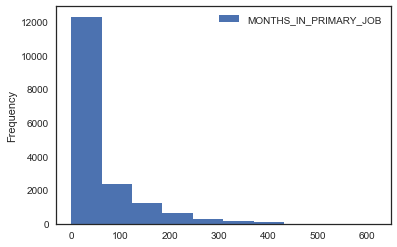

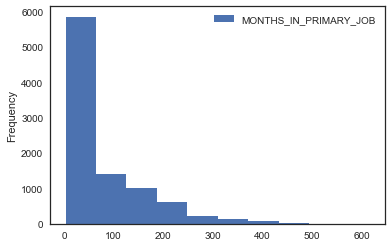

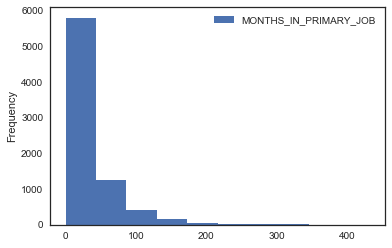

In [141]:
hist = data[['MONTHS_IN_PRIMARY_JOB']].plot.hist(bins=10)

hist = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']!='T'].plot.hist(bins=10) 

hist = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']=='T'].plot.hist(bins=10)

terminated within 0.0-1.0 years (<= 11.0 months): 0.2511621900826446, percentage_sum: 0.2511621900826446
terminated within 1.0-2.0 years (<= 23.0 months): 0.2550361570247934, percentage_sum: 0.506198347107438
terminated within 2.0-3.0 years (<= 35.0 months): 0.1716167355371901, percentage_sum: 0.6778150826446281
terminated within 3.0-4.0 years (<= 47.0 months): 0.09839876033057851, percentage_sum: 0.7762138429752066
terminated within 4.0-5.0 years (<= 59.0 months): 0.06159607438016529, percentage_sum: 0.8378099173553719
terminated within 5.0-6.0 years (<= 71.0 months): 0.03848140495867768, percentage_sum: 0.8762913223140496
terminated within 6.0-7.0 years (<= 83.0 months): 0.026472107438016527, percentage_sum: 0.9027634297520661
terminated within 7.0-8.0 years (<= 95.0 months): 0.022985537190082644, percentage_sum: 0.9257489669421488
terminated within 8.0-9.0 years (<= 107.0 months): 0.016141528925619833, percentage_sum: 0.9418904958677686
terminated within 9.0-10.0 years (<= 119.0 mon

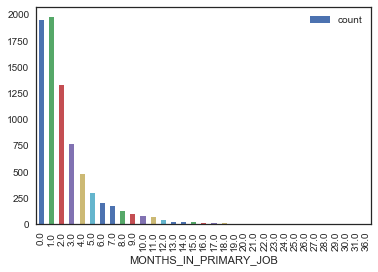

In [142]:
x = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']=='T'].\
    groupby(by = np.floor(data['MONTHS_IN_PRIMARY_JOB']/12)).\
    count().rename(columns={'MONTHS_IN_PRIMARY_JOB':'count'})

ax = x.plot.bar(y='count')
 
for c,i in enumerate(x.index):
    per_year = x.iloc[c:(c+1)].values.sum()/x.values.sum()
    percentage = x.iloc[:(c+1)].values.sum()/x.values.sum()
    print('terminated within {}-{} years (<= {} months): {}'.format(i,i+1,12*(i+1)-1,per_year), 'percentage_sum: {}'.format(percentage),sep=', ')
    if percentage>=0.95:
        break

#### seems like 1(25.1%), 1-2(25.5%), 4(27%) years are good places to set the threshold T

In [143]:
T = 48
# low-risk
# label0 = data[['Worker_ID']][((data['VOLUNTARY'].isnull()) | (data['VOLUNTARY'] == 1))\
#                            & (data['MONTHS_IN_PRIMARY_JOB']>T)]
label0 = data[['Worker_ID']][data['EMPLOYMENT_STATUS'] == 'A']

# higher risk
# label1 = data[['Worker_ID']][(data['EMPLOYMENT_STATUS'] == 'T') & (data['VOLUNTARY'] == 1)\
#                            & (data['MONTHS_IN_PRIMARY_JOB']<=T)]
                             
label1 = data[['Worker_ID']][(data['EMPLOYMENT_STATUS'] == 'T') & (data['VOLUNTARY'] == 1)]

data = data.drop(columns = ['EMPLOYMENT_STATUS','VOLUNTARY']) #'MONTHS_IN_PRIMARY_JOB'

print(label0.shape, label1.shape, data.shape,sep=' ')

label0['label'] = 0
label1['label'] = 1
label = pd.concat([label0,label1],axis=0)

(9376, 1) (6528, 1) (17133, 37)


In [144]:
# T0 = 12
# T1 = 24
# T2 = 48

# # low-risk
# label0 = data[['Worker_ID']][((data['VOLUNTARY'].isnull()) | (data['VOLUNTARY'] == 1))\
#                            & (data['MONTHS_IN_PRIMARY_JOB']>T2)]

# # higher risk
# label1 = data[['Worker_ID']][(data['EMPLOYMENT_STATUS'] == 'T') & (data['VOLUNTARY'] == 1)\
#                            & (data['MONTHS_IN_PRIMARY_JOB']<=T2) & (data['MONTHS_IN_PRIMARY_JOB']>T1)]

# label2 = data[['Worker_ID']][(data['EMPLOYMENT_STATUS'] == 'T') & (data['VOLUNTARY'] == 1)\
#                            & (data['MONTHS_IN_PRIMARY_JOB']<=T1) & (data['MONTHS_IN_PRIMARY_JOB']>T0)]

# label3 = data[['Worker_ID']][(data['EMPLOYMENT_STATUS'] == 'T') & (data['VOLUNTARY'] == 1)\
#                            & (data['MONTHS_IN_PRIMARY_JOB']<=T0)]

# print(label0.shape, label1.shape, label2.shape, label3.shape, data.shape,sep=' ')
# data = data.drop(columns = ['EMPLOYMENT_STATUS','VOLUNTARY','MONTHS_IN_PRIMARY_JOB'])


# label0['label'] = 0
# label1['label'] = 1
# label2['label'] = 2
# label3['label'] = 3
# label = pd.concat([label0,label1,label2,label3],axis=0)

In [145]:
data = data.merge(label, how='right')
data.set_index('Worker_ID',inplace=True)

In [146]:
data.head()

,SEX,EDUCATION_LEVEL,MONTHS_IN_PRIMARY_JOB,PRIMARY_APPT_SALARY,JOB_GRADE,IN_UNION,PAY_CYCLE,Career_Salary_Growth,Percent_Career_Salary_Growth,Number_of_Sal_Adjustments,Number_of_Reclass,Age_start,Age_last,Is_First,Local,US,Has_Manager,sex_diff,race_diff,edu_diff,RACE_A,RACE_B,RACE_C,RACE_P,RACE_R,RACE_S,RACE_U,RACE_Z,MARITAL_STATUS_D,MARITAL_STATUS_M,MARITAL_STATUS_S,MARITAL_STATUS_W,GRANT_PAID_F,GRANT_PAID_N,GRANT_PAID_P,IS_IT,label
Worker_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,4,10,32714.00,25,0,0,6714.00,0.2582,0,0,23,27.0,0,1,1,1,0,0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
5,1,1,4,29120.00,24,0,0,0.00,0.0000,0,0,21,23.0,0,1,1,1,1,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1
6,0,1,26,27895.49,24,0,0,895.49,0.0331,0,0,23,25.0,1,0,1,1,0,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1
7,1,1,49,41593.00,26,0,0,18280.00,0.7841,0,0,27,31.0,1,0,1,1,1,0,5.0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1
8,1,4,18,33014.00,24,0,0,1514.00,0.0480,0,0,31,32.0,1,0,1,1,0,0,2.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1


In [147]:
data.to_csv('final_data.csv')

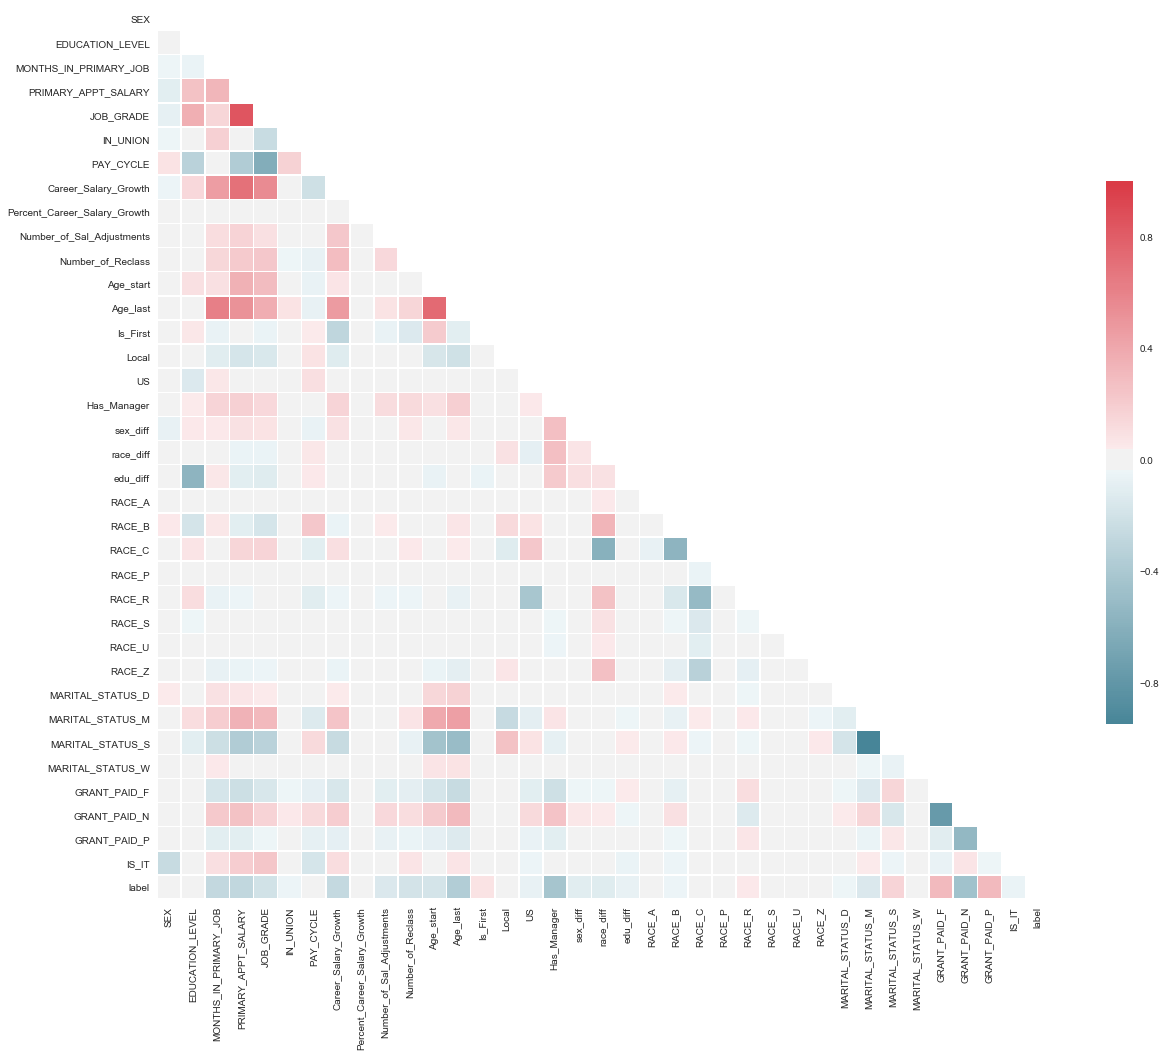

In [148]:
sns.set(style="white")

corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [149]:
y = data[['label']].values
X = data.drop(columns='label')
X = X.values

## PCA

In [ ]:
from sklearn

## Logistic Regression

In [30]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(data.drop(columns='label'), data[['label']])
# print('Resampled dataset shape %s' % Counter(y_res))

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='label'), data[['label']], test_size=0.3)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

lr = LogisticRegression().fit(x_train, y_train)
y_pred = lr.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("f1_score:",f1_score(y_test, y_pred))

Accuracy: 0.8036462699077954
Precision: 0.8569405099150141
Recall: 0.622107969151671
f1_score: 0.7208817396484958


/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix
ROC curve 
balance accuracy
f1 score
vif

### Random Forest & Feature Importance

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(n_estimators = 100,criterion='entropy',max_features=0.5)
rfc.fit(x_train, y_train)
f = sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), data.drop(columns='label').columns), 
             reverse=True)
print(f)
y_pred = rfc.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("f1_score:", f1_score(y_test, y_pred))

/Users/yang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


[(0.1333, 'PRIMARY_APPT_SALARY'), (0.1229, 'MONTHS_IN_PRIMARY_JOB'), (0.1178, 'Career_Salary_Growth'), (0.115, 'Has_Manager'), (0.1008, 'GRANT_PAID_N'), (0.0845, 'Age_last'), (0.0552, 'Age_start'), (0.034, 'JOB_GRADE'), (0.0316, 'edu_diff'), (0.0239, 'EDUCATION_LEVEL'), (0.021, 'GRANT_PAID_P'), (0.016, 'Percent_Career_Salary_Growth'), (0.0121, 'Local'), (0.0109, 'Is_First'), (0.0107, 'SEX'), (0.0106, 'Number_of_Reclass'), (0.0104, 'GRANT_PAID_F'), (0.0102, 'sex_diff'), (0.0099, 'race_diff'), (0.0099, 'Number_of_Sal_Adjustments'), (0.0078, 'RACE_C'), (0.0069, 'PAY_CYCLE'), (0.0067, 'MARITAL_STATUS_M'), (0.0065, 'MARITAL_STATUS_S'), (0.0062, 'RACE_B'), (0.006, 'IS_IT'), (0.0057, 'US'), (0.0052, 'RACE_R'), (0.0041, 'RACE_Z'), (0.0018, 'MARITAL_STATUS_D'), (0.001, 'RACE_S'), (0.0003, 'RACE_U'), (0.0003, 'RACE_A'), (0.0003, 'MARITAL_STATUS_W'), (0.0003, 'IN_UNION'), (0.0, 'RACE_P')]
Accuracy: 0.8413663034367141
Precision: 0.8754740834386852
Recall: 0.712082262210797
f1_score: 0.785370002835

### Neural Nets

In [33]:
# see other notebook

### SVM

In [34]:
from sklearn.svm import SVC

svm = SVC(gamma='auto')
svm.fit(x_train, y_train) 
y_pred = svm.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("f1_score:", f1_score(y_test, y_pred))

/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8002933780385583
Precision: 0.8774733637747336
Recall: 0.59280205655527
f1_score: 0.7075790119668609


In [35]:
# import pandas as pd
# import numpy as np

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
# from sklearn.preprocessing import StandardScaler

# data = pd.read_csv('final_data.csv')

# x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='label'), data[['label']], test_size=0.3)
# scaler = StandardScaler()
# scaler.fit(x_train)
# x_train = scaler.transform(x_train)
# x_test = scaler.transform(x_test)

In [36]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [37]:
# from sklearn.metrics import mean_squared_error
# data_dmatrix = xgb.DMatrix(data=np.asarray(data.drop(columns='label')),label= np.asarray(data['label']))

xg = XGBClassifier()
xg.fit(x_train, y_train)

# y_pred = xg.predict(x_test)

# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("f1_score:", f1_score(y_test, y_pred))

/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [38]:
models = {}
models['Logistic Regression'] = lr
models['Random Forest'] = rfc
models['SVM'] = svm
models['XGBoost'] = xg


In [40]:
from sklearn.model_selection import KFold,cross_val_score
acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=col)
i = 0
# evaluate each model using cross-validation
for name, model in models.items():
    kfold = KFold(n_splits=10)  # 10-fold cross-validation

    cv_acc_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionW

/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
1,Random Forest,89.36,0.79,83.28,0.65
3,XGBoost,88.99,0.94,82.86,0.68
0,Logistic Regression,85.25,1.09,79.45,1.16
2,SVM,84.95,1.28,79.18,1.10


In [45]:
np.array(y_train).reshape(1,-1)[0]

array([1, 1, 0, ..., 0, 1, 0])